## Script for Figure 5a and b

In this script, a fully expanded C3 source leaf with plastidic ATP shuttles constrained based on published studies is modelled in a scenario when photon uptake  not forced on the system. Fluxes are observed for Figure 5a and 5b 

In [1]:
#import functions from library
from libsbml import readSBML
from cobra import io,flux_analysis
import re
from cobra.core import Metabolite, Reaction
from studyFunctions import *

#import model. Update file name and location in the next line
cobra_model = io.sbml.create_cobra_model_from_sbml_file("core_model.xml")

#set up a diel model, allow for day-night metabolite accumulations and constrain model to represent C3 leaf diel metabolism
cobra_model=setupDielModel(cobra_model,"MetabolitesToTransfer.txt")

0.7 MAL_v1 + 0.3 aMAL_v1 <=> 0.7 MAL_v2 + 0.3 aMAL_v2
0.5 CIT_v1 + 0.5 aCIT_v1 <=> 0.5 CIT_v2 + 0.5 aCIT_v2
bHIS_v1 --> bHIS_v2


##### Increase upper and lower bounds to 2000 and -2000 respectively in order to allow for PPFD upto 1500

In [2]:
for rxn in cobra_model.reactions:
    if rxn.lower_bound < -999:
        rxn.lower_bound = -2000
    if rxn.upper_bound > 999:
        rxn.upper_bound = 2000

##### Constrain chlorplast ATP shuttles based on published data

In [3]:
#For PEP-Pyr shuttle, constrain cplast PPDK based on Ishimaru, K., Ichikawa, H., Matsuoka, M., & Ohsugi, R. (1997). Analysis of a C4 maize pyruvate, orthophosphate dikinase expressed in C3 transgenic Arabidopsis plants. Plant Science, 129(1), 57-64.
cobra_model.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p1").lower_bound = 0
cobra_model.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p1").upper_bound = 0.03375
#For TP-3PGA shuttle, constrain cytosolic phosphorylating GAPDH activity based on Gibon, Y., et al(2004). A robot-based platform to measure multiple enzyme activities in Arabidopsis using a set of cycling assays: comparison of changes of enzyme activities and transcript levels during diurnal cycles and in prolonged darkness. The Plant Cell, 16(12), 3304-3325.
cobra_model.reactions.get_by_id("GAPOXNPHOSPHN_RXN_c1").lower_bound = -95.387597
cobra_model.reactions.get_by_id("GAPOXNPHOSPHN_RXN_c1").upper_bound = 95.387597
#and constrain cytosolic non-phosphorylating GAPDH based on Strand, Å., Zrenner, R., Trevanion, S., Stitt, M., Gustafsson, P., & Gardeström, P. (2000). Decreased expression of two key enzymes in the sucrose biosynthesis pathway, cytosolic fructose‐1, 6‐bisphosphatase and sucrose phosphate synthase, has remarkably different consequences for photosynthetic carbon metabolism in transgenic Arabidopsis thaliana. The Plant Journal, 23(6), 759-770.
cobra_model.reactions.get_by_id("1_PERIOD_2_PERIOD_1_PERIOD_9_RXN_c1").lower_bound = 0
cobra_model.reactions.get_by_id("1_PERIOD_2_PERIOD_1_PERIOD_9_RXN_c1").upper_bound = 0.33

In [4]:
phloem_model = cobra_model.copy()

### Constrain the model output so that net CO2 uptake matches experimental data for the chosen light input value (200 PPFD)


    Data extracted Fig 3 of Donahue et al 1997, see Script1.py.

In [5]:
"""
x = light, y = net CO2 uptake
y = a + bx + c^2"""
a = 0.0871351015562
b = 0.0291441670197
c = -0.000009013134

light=list()
CO2=list()
for x in range(100,1550,50):
    light.append(x)
    y=((a)+(b*x)+(c*(x**2)))
    CO2.append(y)
    
light_CO2=dict(zip(light, CO2))

import pandas as pd
df = pd.DataFrame(data={"PPFD":light,"Net CO2 uptake":CO2})
df = df[["PPFD","Net CO2 uptake"]]

    Model flux distribution based on assimilation rate based on PPFD data; and write flux distributions and FVA to file for figure 5 a and b

In [6]:
WTphloemOut = dict()
solutiondict_phloem = dict()
FVAdict_phloem = dict()
PPFD_list=list()
mitoATPase=dict()
light_used=dict()

for i in range(100,1550,100):
    PPFD = i
    print("Running PPFD = "+str(i))
    tempModel3 = phloem_model.copy()
    tempModel3.reactions.get_by_id("Photon_tx1").upper_bound = PPFD*0.9
    #tempModel3.reactions.get_by_id("Photon_tx1").lower_bound = PPFD*0.9
    tempModel3.reactions.get_by_id("ATPase_tx1").upper_bound = estimateMaintenance(200)
    tempModel3.reactions.get_by_id("ATPase_tx1").lower_bound = estimateMaintenance(200)
    solution=flux_analysis.parsimonious.pfba(tempModel3)
    WTphloemOut[PPFD] = estimateOutputFromNetCO2(tempModel3,light_CO2[PPFD],verbose=False)
    tempModel3.reactions.get_by_id("diel_biomass").upper_bound = round(WTphloemOut[PPFD],3)
    tempModel3.reactions.get_by_id("diel_biomass").lower_bound = round(WTphloemOut[PPFD],3)
    solution=flux_analysis.parsimonious.pfba(tempModel3)
    solutiondict_phloem[PPFD]=solution.x_dict
    PPFD_list.append(i)
    mitoATPase[i]=tempModel3.reactions.get_by_id("Mitochondrial_ATP_Synthase_m1").x
    light_used[i]=tempModel3.reactions.get_by_id("Photon_tx1").x




Running PPFD = 100
Running PPFD = 200
Running PPFD = 300
Running PPFD = 400
Running PPFD = 500
Running PPFD = 600
Running PPFD = 700
Running PPFD = 800
Running PPFD = 900
Running PPFD = 1000
Running PPFD = 1100
Running PPFD = 1200
Running PPFD = 1300
Running PPFD = 1400
Running PPFD = 1500


,PPFD,Mito ATPase flux,Phloem output flux,Diel phloem output mmol/24h,CO2_tx1,light used,% light used
0,100,1.191826,0.042323,14.626867,2.911420,47.133753,47.133753
1,200,1.813924,0.107314,37.087727,5.555443,83.865694,41.932847
2,300,2.130420,0.167881,58.019824,8.019203,119.938391,39.979464
3,400,2.426572,0.223859,77.365813,10.302700,153.022486,38.255622
4,500,2.638349,0.275607,95.249625,12.405935,184.122761,36.824552
5,600,2.905305,0.322907,111.596635,14.328907,211.779370,35.296562
6,700,3.114379,0.365701,126.386195,16.071616,237.292534,33.898933
7,800,3.298195,0.404099,139.656576,17.634063,259.846441,32.480805
8,900,3.462996,0.438071,151.397223,19.016247,280.029316,31.114368
9,1000,3.608409,0.467611,161.606323,20.218168,297.837735,29.783773


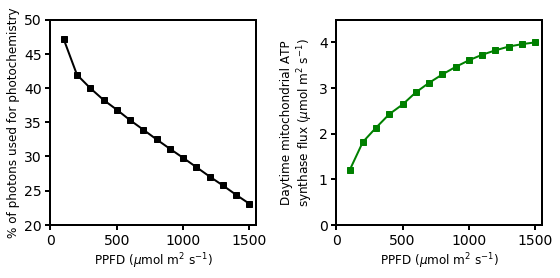

In [7]:
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
plt.rcParams.update({'font.size': 14}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['axes.linewidth']=2 # makes axes line thicker

import pandas as pd
import numpy as np7

df=pd.DataFrame(data={'PPFD':PPFD_list})
df['Mito ATPase flux']= df['PPFD'].map(mitoATPase)
df['Phloem output flux'] =df['PPFD'].map(WTphloemOut)
df['Diel phloem output mmol/24h'] = df['Phloem output flux']*4/1000*60*60*24
df['CO2_tx1']=df['PPFD'].map(light_CO2)
df['light used']=df['PPFD'].map(light_used)
df['% light used']=df['light used']/df['PPFD']*100


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True)
df.plot(ax=ax[0], x='PPFD', y='% light used', legend=False, lw=2, linestyle='-', marker='s', color='black', label = 'Light used')
df.plot(ax=ax[1], x='PPFD', y='Mito ATPase flux', legend=False, lw=2, linestyle='-', marker='s', color='g',label ='M ATPase')
ax[0].set_xlabel('PPFD ($\mu$mol m$^2$ s$^{-1}$)',fontsize=12)
ax[0].set_ylabel('% of photons used for photochemistry',fontsize=12)
ax[1].set_xlabel('PPFD ($\mu$mol m$^2$ s$^{-1}$)',fontsize=12)
ax[1].set_ylabel('Daytime mitochondrial ATP\nsynthase flux ($\mu$mol m$^2$ s$^{-1}$)',fontsize=12)
ax[0].set_ylim(20, 50)
ax[1].set_xlim(0, 1550)
ax[1].set_ylim(0, 4.5)

#ax1.plot(np.nan, 'bs-', label = 'light used')  # Add a blank dataset to ax with correct line for ax2 legend
#ax1.legend(loc = 'lower right', bbox_to_anchor=(1.0, 0.05))
#plt.savefig('8_2_phloem_light_vs_mitoATPase_lightupperBonly.pdf', bbox_inches='tight')
plt.tight_layout()
df